In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import xarray as xr

In [3]:
import cartopy.crs as ccrs

import satpy
from glob import glob

# File Samples

In [8]:
temp_ds = xr.open_dataset(
    '/ships19/cloud/scratch/cphillips/isccp_l1g/demo_20211206/2020/202007/20200701/20200701T0000/ISCCP-NG_L1g_demo_A1_v1_res_0_05deg__temp_11_00um_20200701T0000.nc')

In [9]:
cirrus_ds = xr.open_dataset(
    '/ships19/cloud/scratch/cphillips/isccp_l1g/demo_20211206/2020/202007/20200701/20200701T0000/ISCCP-NG_L1g_demo_A1_v1_res_0_05deg__refl_01_38um_20200701T0000.nc')

In [10]:
wmoid_ds = xr.open_dataset(
    '/ships19/cloud/scratch/cphillips/isccp_l1g/demo_20211206/2020/202007/20200701/20200701T0000/ISCCP-NG_L1g_demo_A1_v1_res_0_05deg__wmo_id_20200701T0000.nc')

In [11]:
wmoid = wmoid_ds.wmo_id
wmoid = wmoid.where(wmoid > 0)

In [12]:
sat_map = {}
remap = {}
for i,l in enumerate(wmoid.attrs['satellite_names'].split(';')):
    id,name = l.split('=')
    id = int(id)
    sat_map[id] = name
    remap[id] = i
remap_r = {v:k for k,v in remap.items()}

In [13]:
wmo_id_remap = wmoid.copy()
wmo_id_remap.values[:] = np.nan
for src,dst in remap.items():
    wmo_id_remap.values[wmoid.values == src] = dst

In [14]:
cycler = rcParams['axes.prop_cycle']

plt.style.use('dark_background')
rcParams['axes.prop_cycle'] = cycler

# rcParams['axes.edgecolor'] = 'white'
# rcParams['xtick.color'] = 'white'
# rcParams['ytick.color'] = 'white'
rcParams['figure.facecolor'] = (1,1,1,0)
rcParams['axes.facecolor'] = (1,1,1,0)
rcParams['legend.framealpha'] = 0
# rcParams['legend.facecolor'] = (0,0,0,1)

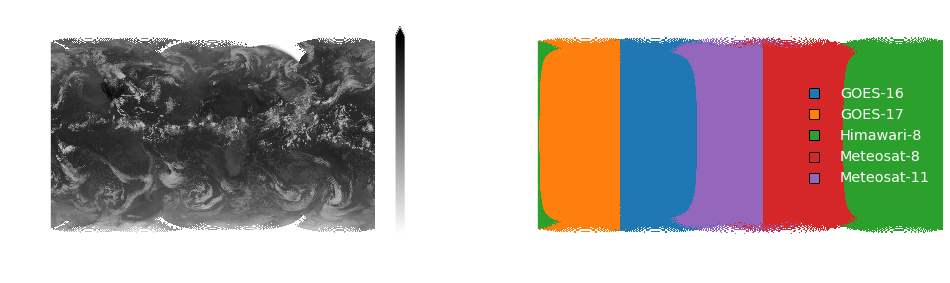

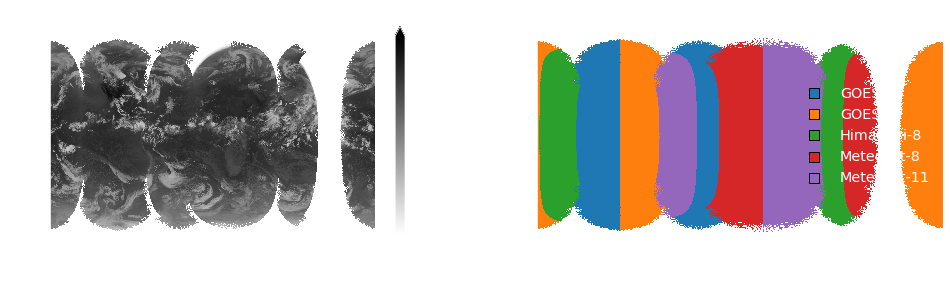

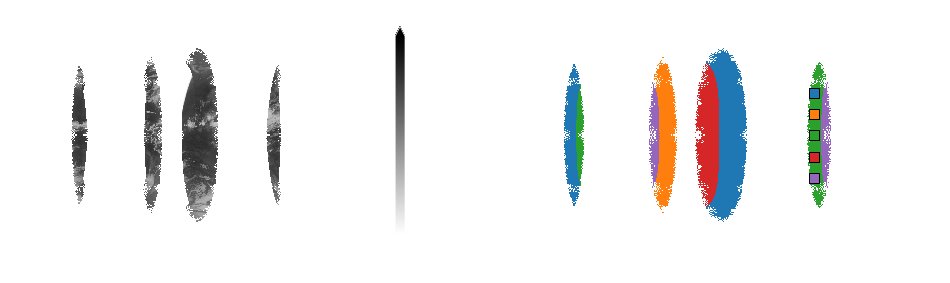

In [15]:
for layer in range(3):
    figure(figsize=(16, 4))
    subplot(121)
    temp_ds.temp_11_00um[0,layer].plot.imshow(vmin=160, vmax=320, cmap='binary', extend='both')
    title(f'11µm BT Layer {layer+1}', fontsize=18)
    subplot(122)
    wmo_id_remap[0,layer].plot.imshow(cmap='tab10', vmin=0, vmax=10, add_colorbar=False)
    _xlim = xlim()
    for dst in remap.values():
        scatter(-1000,0, color=f'C{dst}', label=sat_map[remap_r[dst]], marker='s', edgecolor='k', s=100)
    xlim(_xlim)
    legend(loc='center right', fontsize='x-large')
    title(f'Satellite Mapping Layer {layer+1}', fontsize=18)

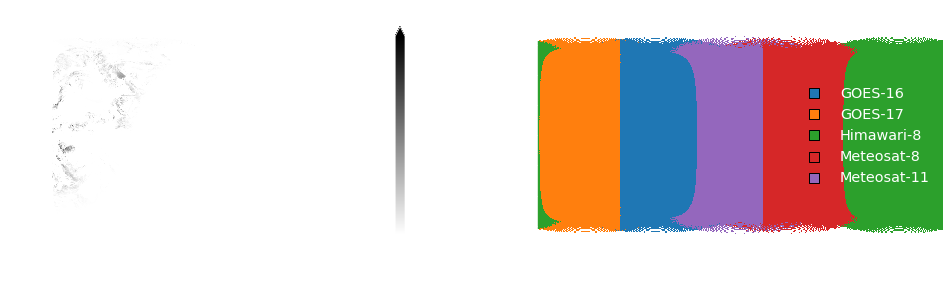

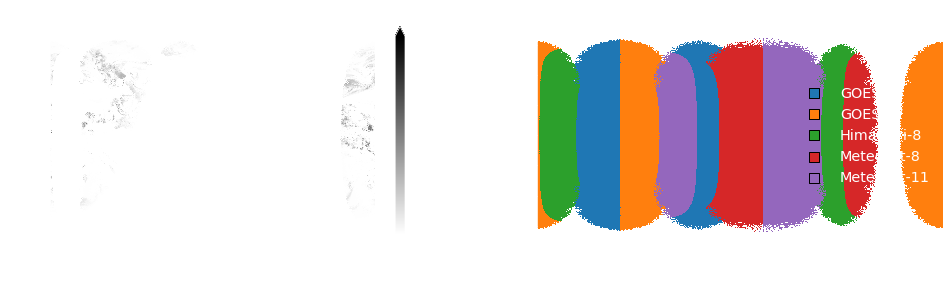

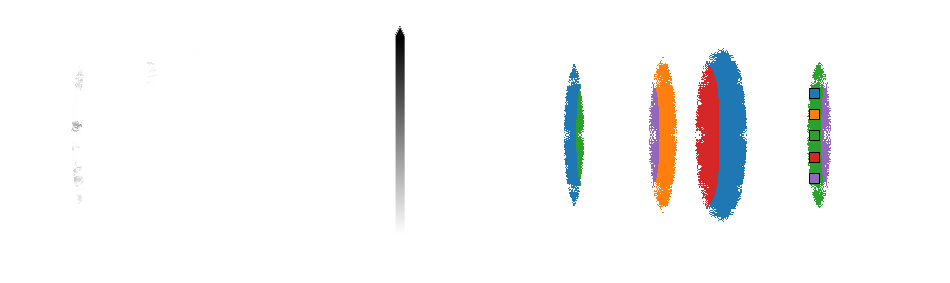

In [16]:
for layer in range(3):
    figure(figsize=(16, 4))
    subplot(121)
    cirrus_ds.refl_01_38um[0,layer].plot.imshow(vmin=0, vmax=100, cmap='binary', extend='both')
    title(f'1.38µm Refl. Layer {layer+1}', fontsize=18)
    subplot(122)
    wmo_id_remap[0,layer].plot.imshow(cmap='tab10', vmin=0, vmax=10, add_colorbar=False)
    _xlim = xlim()
    for dst in remap.values():
        scatter(-1000,0, color=f'C{dst}', label=sat_map[remap_r[dst]], marker='s', edgecolor='k', s=100)
    xlim(_xlim)
    legend(loc='center right', fontsize='x-large')
    title(f'Satellite Mapping Layer {layer+1}', fontsize=18)

# Index

## 500m

In [17]:
src_f = '../index/g16/refl_00_65um/src_index.dat'
dst_f = '../index/g16/refl_00_65um/dst_index.dat'

In [18]:
files = glob('../l1b/2020/202007/20200701/20200701T0000/g16/refl_00_65um/OR_ABI-L1b-RadF-M6*')
scene = satpy.Scene(files, reader='abi_l1b')
scene.load(['C02'])
area = scene['C02'].attrs['area']

/data/cphillips/miniconda3/envs/dev/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [19]:
%%time
coords = area.get_lonlats(nprocs=8)

CPU times: user 7.8 s, sys: 49.3 s, total: 57.1 s
Wall time: 1min 41s


### 500 nadir

In [20]:
#florida_extent = [-88, -79, 24, 31]
florida_extent = [-82, -79, 24, 27]

In [58]:
satlon = coords[0]
satlat = coords[1]

In [59]:
src_index = np.memmap(src_f, mode='r', dtype=np.uint32)
dst_index = np.memmap(dst_f, mode='r', dtype=np.uint32)

In [60]:
row,col = np.unravel_index(dst_index, (1800*2,3600*2))
lat = 90 - (row/10/2)
lon = (col/10/2)-180

In [61]:
mask = (lon > florida_extent[0]) & (lon < florida_extent[1]) & (lat > florida_extent[2]) & (lat < florida_extent[3])

In [62]:
lat = lat[mask]
lon = lon[mask]
src_index = src_index[mask]
dst_index = dst_index[mask]

In [63]:
satlat = satlat.ravel()[src_index]
satlon = satlon.ravel()[src_index]

In [64]:
row = row[mask]
col = col[mask]

In [65]:
cycler = rcParams['axes.prop_cycle']

plt.style.use('dark_background')
rcParams['axes.prop_cycle'] = cycler

rcParams['figure.facecolor'] = (1,1,1,0)
rcParams['axes.facecolor'] = (1,1,1,0)
rcParams['legend.framealpha'] = 0

In [66]:
#colors = np.array(['#009688','#ffab40','#4dd0e1','#eeff41'])[(row % 2)*2 + (col % 2)]
colors = np.array(['blueviolet','hotpink','dodgerblue','deeppink'])[(row % 2)*2 + (col % 2)]

Text(0.5, 1.0, 'GOES-16 500m to 0.05 degree')

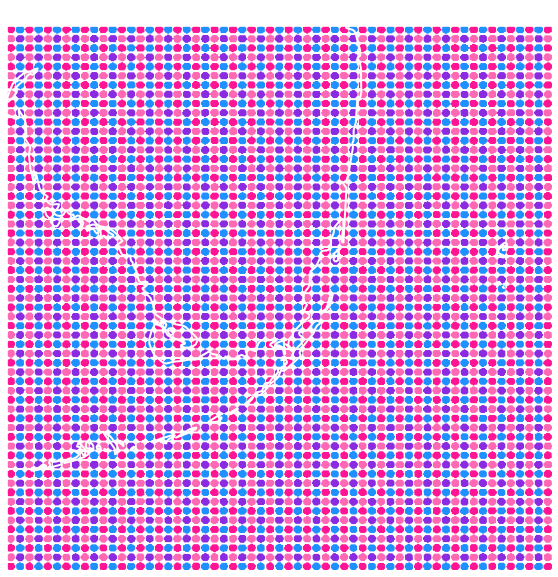

In [72]:
figure(figsize=(10,10))
ax = axes(projection=ccrs.PlateCarree())
ax.scatter(satlon, satlat, transform=ccrs.PlateCarree(), s=1, c=colors)
ax.coastlines('10m', color='w', linewidth=2)
xlim([satlon.min(), satlon.max()])
ylim([satlat.min(), satlat.max()])
title('GOES-16 500m to 0.05 degree', fontsize=18)

Text(0.5, 1.0, 'GOES-16 500m to 0.05 degree')

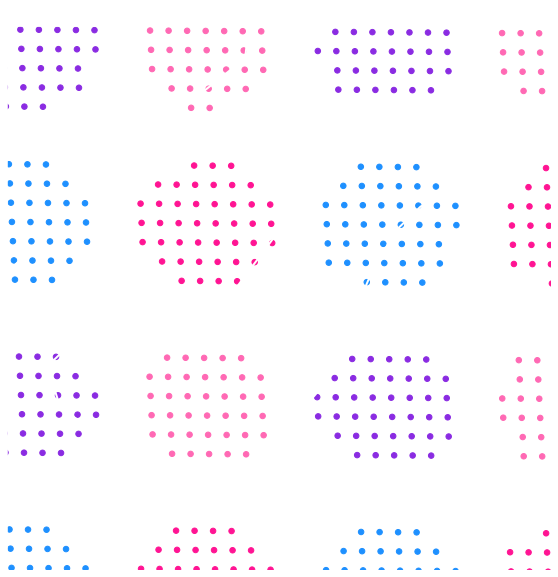

In [68]:
figure(figsize=(10,10))
ax = axes(projection=ccrs.PlateCarree())
ax.scatter(satlon, satlat, transform=ccrs.PlateCarree(), s=30, c=colors)
ax.coastlines('10m', color='w', linewidth=2)
xlim([-80.38, -80.23])
ylim([25.23,25.38])
title('GOES-16 500m to 0.05 degree', fontsize=18)

## 500m oblique

In [73]:
sf_extent = [-123.2, -121.7, 37.37, 38.5]
sf_extent = [-92.15, -88.2, -1.9, 1.13]
sf_extent = [1.79, 7.87, 0, 6.2]
sf_extent = [-25.4, -22.54, 14.56, 17.5]
sf_extent = [-11, -8, 4, 7]

In [74]:
satlon = coords[0]
satlat = coords[1]

In [75]:
src_index = np.memmap(src_f, mode='r', dtype=np.uint32)
dst_index = np.memmap(dst_f, mode='r', dtype=np.uint32)

In [77]:
row,col = np.unravel_index(dst_index, (1800*2,3600*2))
lat = 90 - (row/10/2)
lon = (col/10/2)-180

In [78]:
mask = (lon > sf_extent[0]) & (lon < sf_extent[1]) & (lat > sf_extent[2]) & (lat < sf_extent[3])

In [79]:
lat = lat[mask]
lon = lon[mask]
src_index = src_index[mask]
dst_index = dst_index[mask]

In [80]:
satlat = satlat.ravel()[src_index]
satlon = satlon.ravel()[src_index]

In [81]:
row = row[mask]
col = col[mask]

In [82]:
cycler = rcParams['axes.prop_cycle']

plt.style.use('dark_background')
rcParams['axes.prop_cycle'] = cycler

rcParams['figure.facecolor'] = (1,1,1,0)
rcParams['axes.facecolor'] = (1,1,1,0)
rcParams['legend.framealpha'] = 0

In [83]:
#colors = np.array(['#009688','#ffab40','#4dd0e1','#eeff41'])[(row % 2)*2 + (col % 2)]
colors = np.array(['blueviolet','hotpink','dodgerblue','deeppink'])[(row % 2)*2 + (col % 2)]

Text(0.5, 1.0, 'GOES-16 500m to 0.05 degree (west Africa)')

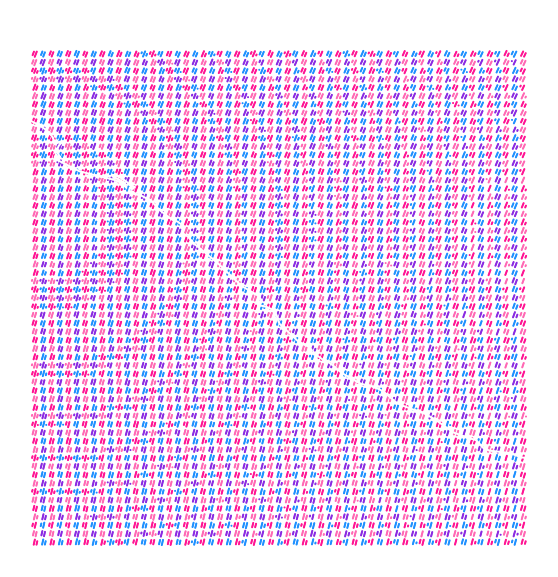

In [87]:
figure(figsize=(10,10))
ax = axes(projection=ccrs.PlateCarree())#ccrs.Geostationary(central_longitude=-70))
ax.scatter(satlon, satlat, transform=ccrs.PlateCarree(), s=1, c=colors)
ax.coastlines('10m', color='w', linewidth=2)
# xlim([satlon.min(), satlon.max()], transform=ccrs.PlateCarree())
# ylim([satlat.min(), satlat.max()])
title('GOES-16 500m to 0.05 degree (west Africa)', fontsize=18)
# xlim([-24, -23.5])
# ylim([15., 15.5])

(5.5, 6.0)

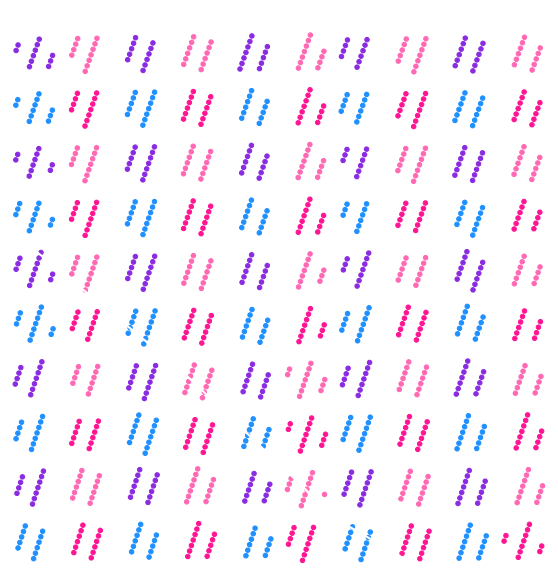

In [90]:
figure(figsize=(10,10))
ax = axes(projection=ccrs.PlateCarree())#ccrs.Geostationary(central_longitude=-70))
ax.scatter(satlon, satlat, transform=ccrs.PlateCarree(), s=20, c=colors)
ax.coastlines('10m', color='w', linewidth=2)
#xlim([satlon.min(), satlon.max()], transform=ccrs.PlateCarree())
#ylim([satlat.min(), satlat.max()])
title('GOES-16 500m to 0.05 degree (west Africa)', fontsize=18)
xlim([-10, -9.5])
ylim([5.5, 6])